## Faster R-CNN Setup

We first add Faster R-CNN to our PYTHONPATH. Faster-RCNN will use a pretrained neural net that was trained on IMAGENET. We leverage this pre-existing model (VGG16) to extract bounding boxes for our potential classes. As mentioned in our paper, this pre-trained image net relies on labeled data, so effectively, we're leveraging it in order to make a more finely tuned dataset. However, if we want to recognize completely novel objects, we can simply use DeepBox - that is, we don't need to have ANY prior dataset. We emphasize this in our paper as well.

In [2]:
import os
import sys

#Set the correct environment variables
os.environ['SNORKELHOME']='/home/thomas/snorkel'
os.environ['PYTHONPATH']=':/home/thomas/snorkel:/home/thomas/snorkel/treedlib:/home/thomas/snorkel:/home/thomas/snorkel/treedlib'
os.environ['PATH']='/home/thomas/bin:/home/thomas/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/thomas/snorkel:/home/thomas/snorkel/treedlib:/home/thomas/snorkel:/home/thomas/snorkel/treedlib'

#Add python to the system path so that python can find the package
sys.path.append('/home/thomas/snorkel')
sys.path.append('/home/thomas/snorkel/treedlib')

#Add R-CNN Tools to the system path -> This in turn adds the correct R-CNN paths, see _init_paths.py in the Tools folder
sys.path.append('/home/thomas/py-faster-rcnn/tools')

In [3]:
#From the demo py-faster-rcnn script <- Using a pre-trained neural network

import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('VGG16',
                  'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF',
                  'ZF_faster_rcnn_final.caffemodel')}


def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    
def filter_detections(im, dets, thresh=0.5):
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return
    return dets[inds]

def detectAndDrawObjects(net, image):
    """Detect object classes in an image using pre-computed object proposals."""
    
    # Load the demo image
    if(type(image) is str): #If given a string image path name, read in the image
        im = cv2.imread(image)
    else: #Otherwise, assume that image is the actual image
        im = image

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[6:8]): #We only care about the car and bus classes
        cls_ind += 6 # because we start at the 6th class
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]

        vis_detections(im, cls, dets, thresh=CONF_THRESH)
        
def detectAndReturnObjects(net, image):
    """Detect object classes in an image using pre-computed object proposals."""
    
    # Load the demo image
    if(type(image) is str): #If given a string image path name, read in the image
        im = cv2.imread(image)
    else: #Otherwise, assume that image is the actual image
        im = image
        
    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    
    boxesArray = np.empty((0,5), float)
    
    for cls_ind, cls in enumerate(CLASSES[6:8]): #We only care about the car and bus classes
        cls_ind += 6 # because we start at the 6th class
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        
        tempBoxes = filter_detections(im, dets, thresh=CONF_THRESH)
        if tempBoxes is not None:
            boxesArray = np.vstack((boxesArray, tempBoxes))

    return boxesArray



Loaded network /home/thomas/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel
Detection took 0.306s for 300 object proposals
Detection took 0.152s for 300 object proposals
Detection took 0.155s for 300 object proposals


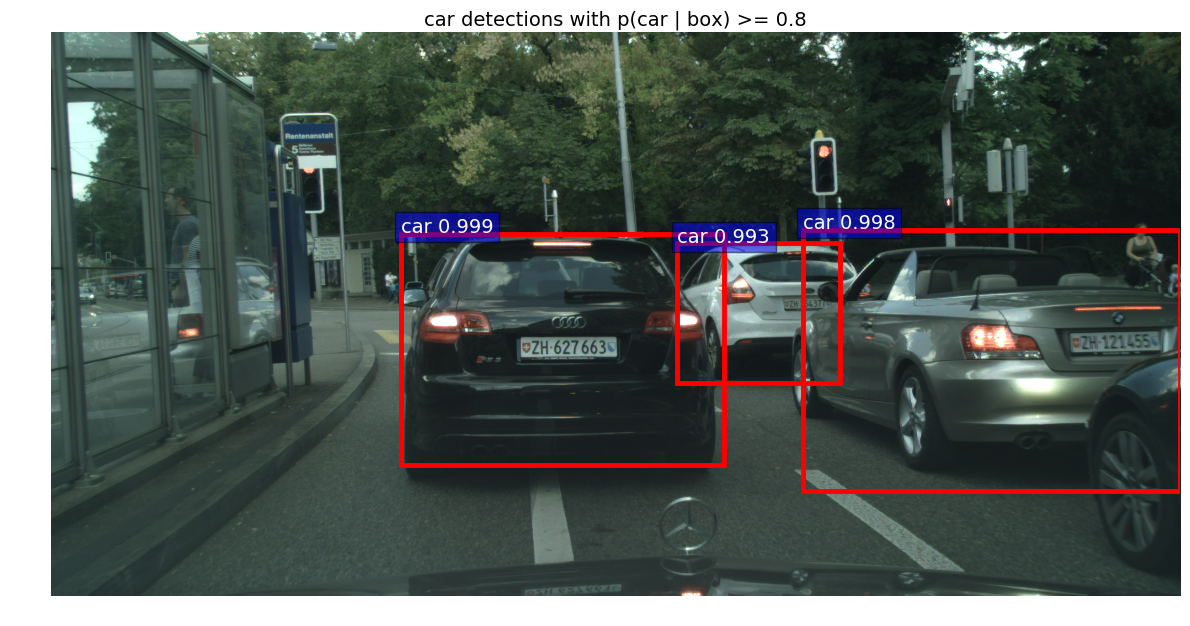

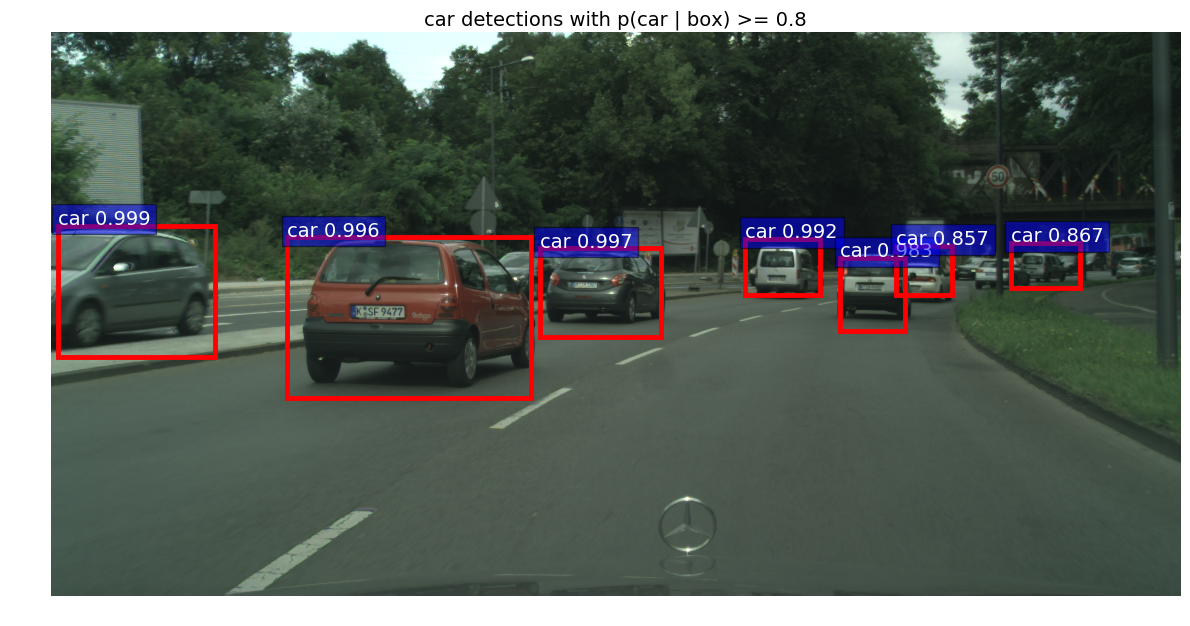

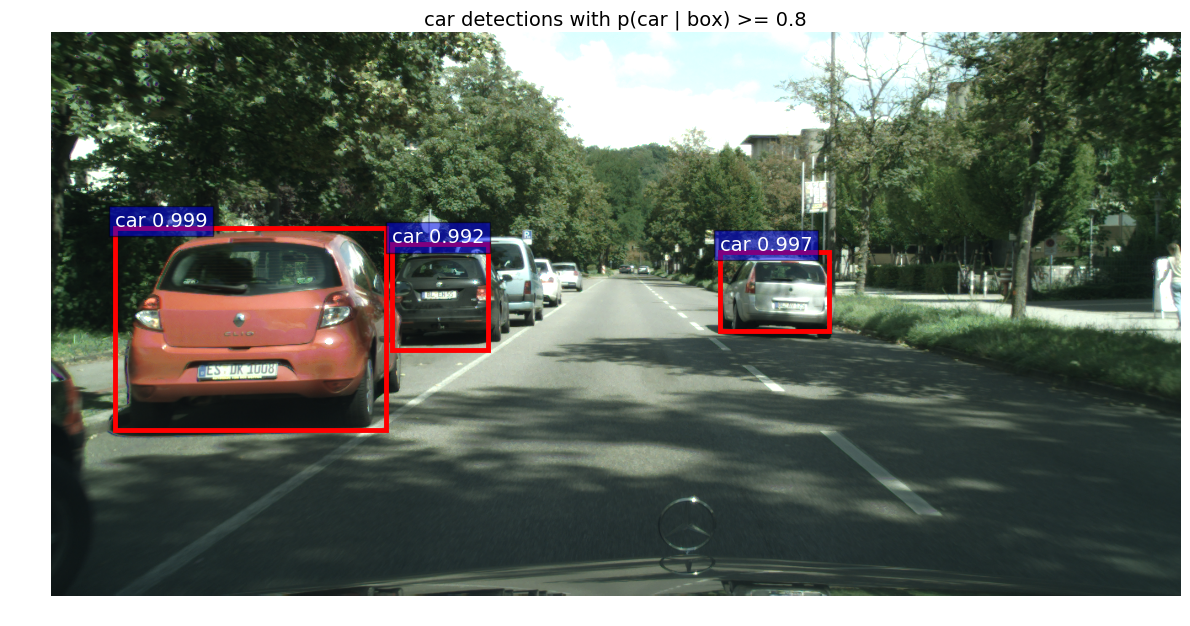

In [4]:
cfg.TEST.HAS_RPN = True  # Use RPN for proposals

prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16'][0],
                        'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS['vgg16'][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

#Train on GPU ID 0 <- Only works if you've configured CUDA and your GPU correctly
caffe.set_mode_gpu()
caffe.set_device(0)
cfg.GPU_ID = 0
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print '\n\nLoaded network {:s}'.format(caffemodel)

#Take our test images and run R-CNN on them
im_path = '/home/thomas/pixy/Test_Cars/'
im_names = ['1.png', '2.png', '3.png']
im_names = [im_path + tempIm for tempIm in im_names]

for im_name in im_names:
    detectAndDrawObjects(net, im_name)

plt.show()

Now let's just get the boxes out. Each box entry will have the format $\begin{bmatrix} x1 & y1 & x2 & y2 & score \end{bmatrix}$ where $0 \leq score \leq 1$.



Loaded network /home/thomas/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel


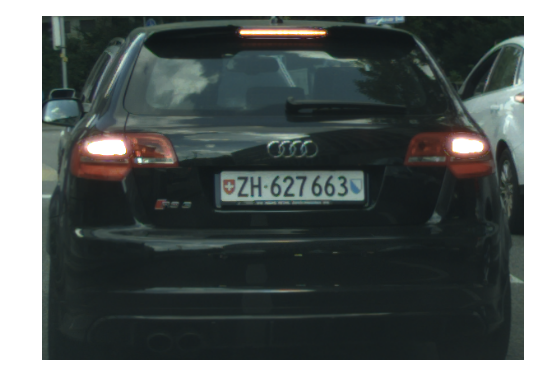

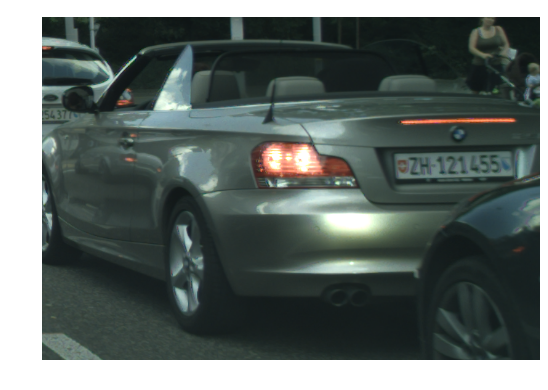

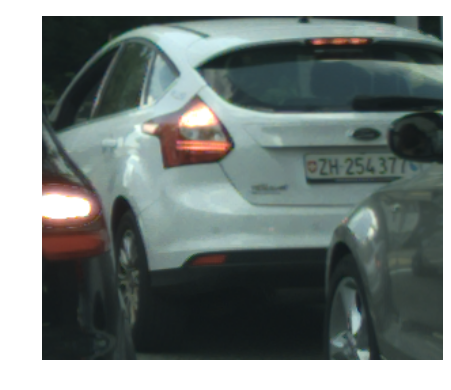

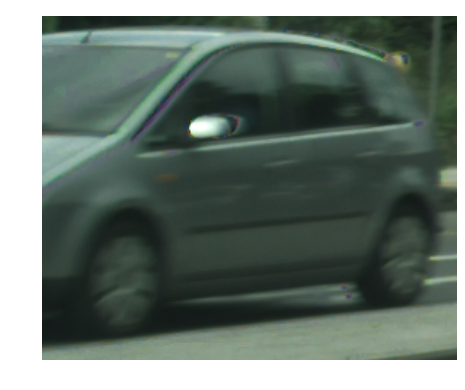

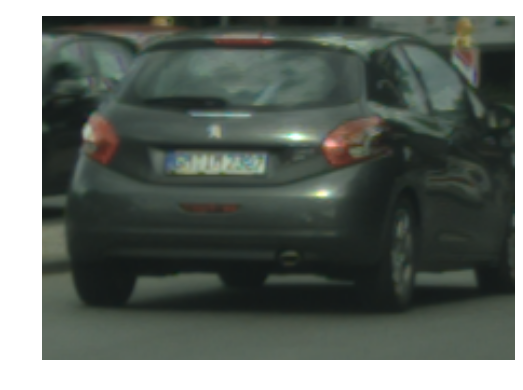

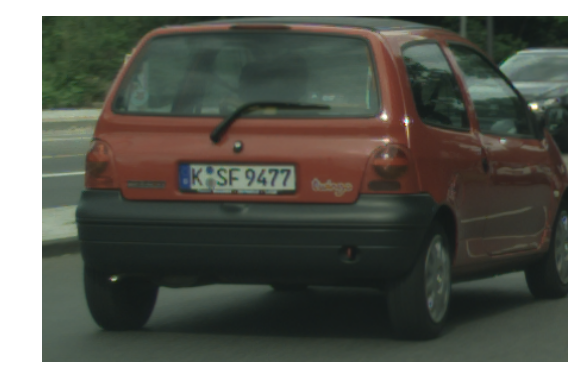

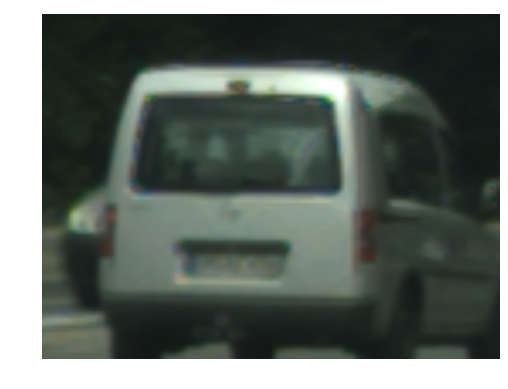

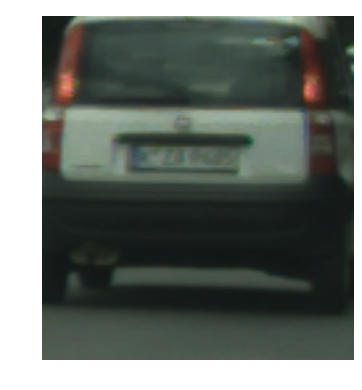

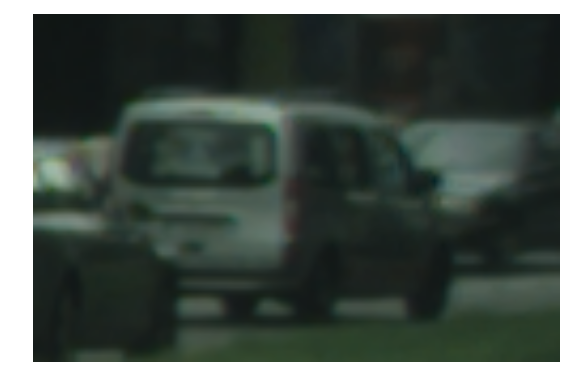

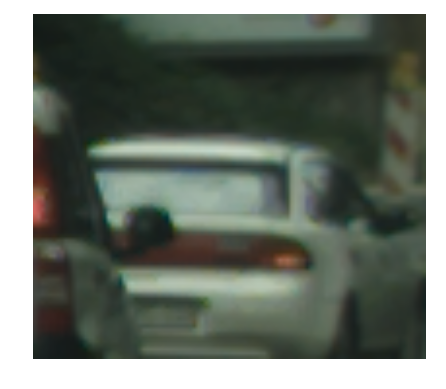

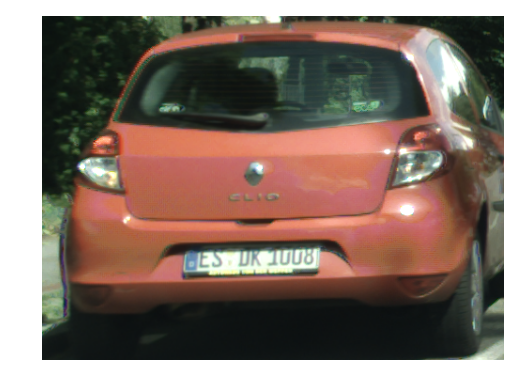

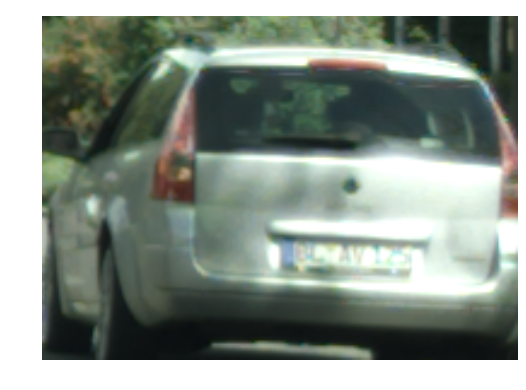

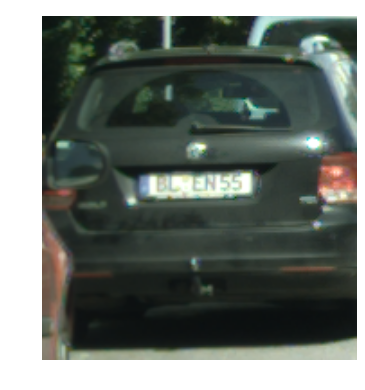

In [5]:
import scipy.misc

cfg.TEST.HAS_RPN = True  # Use RPN for proposals

prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16'][0],
                        'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS['vgg16'][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

#Train on GPU ID 0 <- Only works if you've configured CUDA and your GPU correctly
caffe.set_mode_gpu()
caffe.set_device(0)
cfg.GPU_ID = 0
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print '\n\nLoaded network {:s}'.format(caffemodel)

#Take our test images and run R-CNN on them
im_path = '/home/thomas/pixy/Test_Cars/'
im_names = ['1.png', '2.png', '3.png']
im_names = [im_path + tempIm for tempIm in im_names]
output_path = '/home/thomas/pixy/Test_Cars_Output/'
outputCounter = 0

#For some reason, cv2 just won't write the images if the directory doesn't exist
if not os.path.isdir(output_path):
    os.mkdir(output_path)

for im_name in im_names:
    boxes = detectAndReturnObjects(net, im_name)
    
    for box in boxes:
        im = cv2.imread(im_name)
        box = [int(num) for num in box]
        boxIm = im[box[1]:box[3], box[0]:box[2],:]
        
        #Write the segmented output
        cv2.imwrite(output_path + str(outputCounter) + '.jpg',boxIm)
        outputCounter += 1
        
        boxIm = cv2.cvtColor(boxIm, cv2.COLOR_BGR2RGB) #matplotlib uses a different storage format than cv2, this is just for displaying images
        plt.imshow(boxIm) #Rows of the image are the y axis, columns are the x axis
        plt.axis('off')
        plt.tight_layout()
        plt.show()

R-CNN does a great job extracting the cars from our image. Now, let's run it on the real dataset. We'll be using images from the CityScapes dataset. Unfortunately, due to licensing issues, we can't include the CityScapes dataset in our repository (also because we can't upload 10 GB of images to GitHub). To gain access to the dataset, register at https://www.cityscapes-dataset.com/downloads/ and place the training images in the PIXY_PATH/CityScapes/ folder. The training images look extremely similar to the three images provided in the Test_Cars folder.

In [6]:
import scipy.misc
from tqdm import tqdm
from os import listdir
from os.path import isfile, join

cfg.TEST.HAS_RPN = True  # Use RPN for proposals

prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16'][0],
                        'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS['vgg16'][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

#Train on GPU ID 0 <- Only works if you've configured CUDA and your GPU correctly
caffe.set_mode_gpu()
caffe.set_device(0)
cfg.GPU_ID = 0
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print '\n\nLoaded network {:s}'.format(caffemodel)

#Take our test images and run R-CNN on them
im_path = '/home/thomas/pixy/CityScapes/'
im_names = onlyfiles = [f for f in listdir(im_path) if isfile(join(im_path, f))]
im_names = [im_path + tempIm for tempIm in im_names]
output_path = '/home/thomas/pixy/CityScapes_Output/'
outputCounter = 0

#For some reason, cv2 just won't write the images if the directory doesn't exist
if not os.path.isdir(output_path):
    os.mkdir(output_path)

for im_name in tqdm(im_names):
    boxes = detectAndReturnObjects(net, im_name)
    
    for box in boxes:
        im = cv2.imread(im_name)
        box = [int(num) for num in box]
        boxIm = im[box[1]:box[3], box[0]:box[2],:]
        
        #Write the segmented output
        cv2.imwrite(output_path + str(outputCounter) + '.jpg',boxIm)
        outputCounter += 1

  0%|          | 0/2975 [00:00<?, ?it/s]



Loaded network /home/thomas/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel


100%|██████████| 2975/2975 [16:07<00:00,  3.54it/s]


In [7]:
print("Segmented " + str(outputCounter) + " cars!")

Segmented 7608 cars!


## Visual Bag of Words

For each of our classes, we compute the SIFT features and k-means cluster in order to get our "visual words". A great overview of this method:: http://vision.ucla.edu/~vedaldi/assets/pubs/vedaldi10vlfeat-tutorial.pdf

1) First we provide the directory of our images and split our dataset into train and testing data.

In [9]:
#Import necessary libraries, following is based on the PHOW script, with modifications
import phow_caltech101 as phow
from datetime import datetime
from os.path import exists
from sklearn.kernel_approximation import AdditiveChi2Sampler
from cPickle import dump, load
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt

#Define initial configuration setup variables
IMAGEDIRECTORY = 'CityScapes_Output_Labels' #ATTENTION: SET IMAGE DIRECTORY HERE, MUST BE IN SAME FOLDER AS NOTEBOOK
IDENTIFIER = 'cityscape1' #The identifier is a string that we use to cache our datasets with - using an identifier allows us to retrieve things from our cache later
OVERWRITE = False #Ignore the cache?
NUMTRAIN = 20 #From each directory, how many images do we want to train with to find our visual words
NUMTEST = 0 #From each directory, how many images do we want to use to test how good our visual words clustering is
NUMCLASSES = 4 #How many folders do we have, aka how many visual word clusterings do we have to do
NUMWORDS = 600 #How many words do we want to use to describe our image classes

conf = phow.Configuration(IDENTIFIER)
conf.setImagePath(IMAGEDIRECTORY)
conf.setNumTrain(NUMTRAIN)
conf.setNumTest(NUMTEST)
conf.setNumClasses(NUMCLASSES)
conf.setNumWords(NUMWORDS)

print str(datetime.now()) + '| Finished configuring system'

classes = phow.get_classes(conf.calDir, conf.numClasses)

model = phow.Model(classes, conf)

all_images, all_images_class_labels = phow.get_all_images(classes, conf)
selTrain, selTest = phow.create_split(all_images, conf)

print str(datetime.now()) + '| Found classes and created split'

2016-12-10 04:44:22.756051| Finished configuring system
2016-12-10 04:44:22.757268| Found classes and created split


We now use our selTrain data set and find our visual bag of words, we've specified to find 600 visual words.

In [10]:
##################
# Train vocabulary
##################
print str(datetime.now()) + '| Start training vocabulary - launching threads to do SIFT'
if (not exists(conf.vocabPath)) | OVERWRITE:
    vocab = phow.trainVocab(selTrain, all_images, conf)
    phow.savemat(conf.vocabPath, {'vocab': vocab})
else:
    print str(datetime.now()) + '| Done! Using old vocab from ' + conf.vocabPath
    vocab = phow.loadmat(conf.vocabPath)['vocab']

model.vocab = vocab #The columns of vocab are our visual words

2016-12-10 04:44:26.057395| Start training vocabulary - launching threads to do SIFT
2016-12-10 04:44:33.166771| Now getting visual words via k-means clustering, goes until convergence


Calculate amount of "contribution" each word has to a specific image. (Imagine that the vocab is a set of singular vectors and we're computing our singular values.)

First, we pull out the SIFT vector from each image.

In [11]:
############################
# Compute spatial histograms
############################
print str(datetime.now()) + '| Computing Spatial Histograms'
if (not exists(conf.histPath)) | OVERWRITE:
    hists = phow.computeHistograms(all_images, model, conf, vocab)
    phow.savemat(conf.histPath, {'hists': hists})
else:
    print str(datetime.now()) + '| Found old historams at:' + conf.histPath
    hists = phow.loadmat(conf.histPath)['hists']

  0%|                                                                          |

2016-12-10 04:47:47.709454| Computing Spatial Histograms


100%|##########################################################################|


After that, we use the AdditiveChi2Sampler from sci-kit learn to do a feature mapping (analogously calculating the singular values).

In [12]:
#####################
# Compute feature map
#####################
print str(datetime.now()) + '| Computing Feature Map'
transformer = AdditiveChi2Sampler()
histst = transformer.fit_transform(hists)
train_data = histst[selTrain]
test_data = histst[selTest]

2016-12-10 04:49:06.188772| Computing Feature Map


Fit our word vectors with the Logistic Regression Model using 1, 2, 3, and 4 as our class labels -> corresponding to Bus, Sedan, SUV, and Van.

In [32]:
y = [1] * 20
y = y + [2] * 20
y = y + [3] * 20
y = y + [4] * 20

In [41]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(train_data, y)

logreg.predict_proba(train_data[0].reshape(1,-1))

array([[  9.99666925e-01,   8.14706886e-05,   1.60709303e-05,
          2.35532970e-04]])

As expected, when given a picture from our training dataset of a Bus, Logistic Regression classifies it as a bus with .99966 percent probability. Note that logistic regression normalizes the probabilities such that the class label probabilities sum to 1.

In [94]:
tempLog = logreg.predict_proba(train_data[0].reshape(1,-1))

In [95]:
tempLog

array([[  9.99666925e-01,   8.14706886e-05,   1.60709303e-05,
          2.35532970e-04]])

Now, let's do the visual bag of words on our testing dataset. First, we have to extract the cars from our test dataset.

In [50]:
import scipy.misc
from tqdm import tqdm
from os import listdir
from os.path import isfile, join

cfg.TEST.HAS_RPN = True  # Use RPN for proposals

prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16'][0],
                        'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS['vgg16'][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

#Train on GPU ID 0 <- Only works if you've configured CUDA and your GPU correctly
caffe.set_mode_gpu()
caffe.set_device(0)
cfg.GPU_ID = 0
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print '\n\nLoaded network {:s}'.format(caffemodel)

#Take our test images and run R-CNN on them
im_path = '/home/thomas/pixy/CityScapes_Test/'
im_names = onlyfiles = [f for f in listdir(im_path) if isfile(join(im_path, f))]
im_names = [im_path + tempIm for tempIm in im_names]
output_path = '/home/thomas/pixy/CityScapes_Test_Output/'
outputCounter = 0

#For some reason, cv2 just won't write the images if the directory doesn't exist
if not os.path.isdir(output_path):
    os.mkdir(output_path)

for im_name in tqdm(im_names):
    boxes = detectAndReturnObjects(net, im_name)
    
    for box in boxes:
        im = cv2.imread(im_name)
        box = [int(num) for num in box]
        boxIm = im[box[1]:box[3], box[0]:box[2],:]
        
        #Write the segmented output
        cv2.imwrite(output_path + str(outputCounter) + '.jpg',boxIm)
        outputCounter += 1

  0%|          | 0/2025 [00:00<?, ?it/s]



Loaded network /home/thomas/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel


100%|██████████| 2025/2025 [11:52<00:00,  3.70it/s]


In [51]:
print("Segmented " + str(outputCounter) + " cars!")

Segmented 6200 cars!


In [61]:
out_names = onlyfiles = [f for f in listdir(output_path) if isfile(join(output_path, f))]
out_names = ['CityScapes_Test_Output/' + tempIm for tempIm in out_names]

In [66]:
tempHistPath = 'tempresults/cityscape1output-hists.py.mat'
OVERWRITE = False #We really don't want to ignore the cache for this, it takes a very long time to compute

In [86]:
############################
# Compute spatial histograms
############################
print str(datetime.now()) + '| Computing Spatial Histograms'
if (not exists(tempHistPath)) | OVERWRITE:
    out_hists = phow.computeHistograms(out_names, model, conf, vocab)
    phow.savemat(tempHistPath, {'hists': out_hists})
else:
    print str(datetime.now()) + '| Found old historams at:' + tempHistPath
    out_hists = phow.loadmat(tempHistPath)['hists']

  0%|                                                                          |

2016-12-10 15:02:41.430337| Computing Spatial Histograms


100%|##########################################################################|


In [89]:
#####################
# Compute feature map
#####################
print str(datetime.now()) + '| Computing Feature Map'
transformer = AdditiveChi2Sampler()
out_histst = transformer.fit_transform(out_hists)

2016-12-10 16:55:05.342900| Computing Feature Map


Out class labels are in the form $\begin{bmatrix} P(Bus|Features) & P(Sedan|Features) & P(SUV|Features) & P(Van|Features) \end{bmatrix}$.

In [123]:
logreg.decision_function(out_histst[135])

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[-3.47155862, -3.50957911, -5.03752508, -9.61345084]])

In [124]:


for out_hist in out_histst:
    tempLog = logreg.predict_proba(out_histst[135].reshape(1,-1))

print(tempLog)

[[ 0.45871954  0.44210317  0.09816006  0.00101722]]


## Snorkel Installation and Setup

First, let's load snorkel into our Jupyter python path. For some reason, the snorkel installation doesn't always work so this is here as a backup. Make sure that you follow the installation instructions in the README as well before executing any code.

In [7]:
import os
import sys

#Set the correct environment variables
os.environ['SNORKELHOME']='/home/thomas/snorkel'
os.environ['PYTHONPATH']=':/home/thomas/snorkel:/home/thomas/snorkel/treedlib:/home/thomas/snorkel:/home/thomas/snorkel/treedlib'
os.environ['PATH']='/home/thomas/bin:/home/thomas/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/thomas/snorkel:/home/thomas/snorkel/treedlib:/home/thomas/snorkel:/home/thomas/snorkel/treedlib'

#Add python to the system path so that python can find the package
sys.path.append('/home/thomas/snorkel')
sys.path.append('/home/thomas/snorkel/treedlib')

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

## Fitting the Generative Model
We estimate the accuracies of the labeling functions without supervision. Specifically, we estimate the parameters of a `NaiveBayes` generative model.

First, we have to specify a sparse matrix with labeling function output. The setup of the matrix is as follows:

Rows of the matrix correspond with individual test images
Columns of the matrix correspond to individual labeling functions
Entries in the matrix are {-1, 0, 1}, the possible outputs of each labeling function

In [7]:
#Setup our sparse array
import numpy as np
from scipy.sparse import csr_matrix
a = csr_matrix((3, 4), dtype=np.int8).toarray() #3 test images, 4 labeling functions, make up labeling function output

a[0,1] = 1

a

array([[0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int8)

In [8]:
#Convert our sparse array into a format that snorkel knows how to deal with
from snorkel.annotations import csr_LabelMatrix
from snorkel.annotations import csr_AnnotationMatrix

a1 = csr_LabelMatrix(csr_AnnotationMatrix(a))

a1

<3x4 sparse matrix of type '<type 'numpy.int8'>'
	with 1 stored elements in Compressed Sparse Row format>

In [11]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(a1, n_iter=1000, rate=1e-5)

gen_model.w

Training marginals (!= 0.5):	3
Features:			4
Begin training for rate=1e-05, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=1e-06 after 10 steps


array([ 0.999985,  0.999985,  0.999985,  0.999985])

In [14]:
train_marginals = gen_model.marginals(a1)

train_marginals

array([ 0.73105563,  0.5       ,  0.5       ])

In [ ]:
from snorkel.learning import LogReg
from snorkel.learning_utils import RandomSearch, ListParameter, RangeParameter

iter_param = ListParameter('n_iter', [250, 500, 1000, 2000])
rate_param = RangeParameter('rate', 1e-4, 1e-2, step=0.75, log_base=10)
reg_param  = RangeParameter('mu', 1e-8, 1e-2, step=1, log_base=10)

disc_model = LogReg()

In [ ]:
searcher = RandomSearch(disc_model, F_train, train_marginals, 10, iter_param, rate_param, reg_param)